# Preliminaries

First install a critical dependency for our code

In [1]:
!pip install keras==2.2.4 # critical dependency

     |████████████████████████████████| 317kB 6.2MB/s 
  Found existing installation: Keras 2.3.0
    Uninstalling Keras-2.3.0:
      Successfully uninstalled Keras-2.3.0


Write requirements to file, anytime you run it, in case you have to go back and recover dependencies.

Latest known such requirements are hosted for each notebook in the companion github repo, and can be pulled down and installed here if needed. Companion github repo is located at https://github.com/azunre/transfer-learning-for-nlp

In [2]:
!pip freeze > kaggle_image_requirements.txt

In [3]:
# Import neural network libraries
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer

# Initialize tensorflow/keras session
sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


In [4]:
# Some other key imports
import os
import re
import pandas as pd
import numpy as np
import random

# Define Tokenization, Stop-word and Punctuation Removal Functions

Before proceeding, we must decide how many samples to draw from each class. We must also decide the maximum number of tokens per email, and the maximum length of each token. This is done by setting the following overarching hyperparameters

In [5]:
Nsamp = 1000 # number of samples to generate in each class - 'spam', 'not spam'
maxtokens = 50 # the maximum number of tokens per document
maxtokenlen = 20 # the maximum length of each token

**Tokenization**

In [6]:
def tokenize(row):
    if row is None or row is '':
        tokens = ""
    else:
        tokens = row.split(" ")[:maxtokens]
    return tokens

**Use regular expressions to remove unnecessary characters**

Next, we define a function to remove punctuation marks and other nonword characters (using regular expressions) from the emails with the help of the ubiquitous python regex library. In the same step, we truncate all tokens to hyperparameter maxtokenlen defined above.

In [7]:
import re

def reg_expressions(row):
    tokens = []
    try:
        for token in row:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)
            token = token[:maxtokenlen] # truncate token
            tokens.append(token)
    except:
        token = ""
        tokens.append(token)
    return tokens

**Stop-word removal**

Let’s define a function to remove stopwords - words that occur so frequently in language that they offer no useful information for classification. This includes words such as “the” and “are”, and the popular library NLTK provides a heavily-used list that will employ.

In [8]:
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')    

# print(stopwords) # see default stopwords
# it may be beneficial to drop negation words from the removal list, as they can change the positive/negative meaning
# of a sentence - but we didn't find it to make a difference for this problem
# stopwords.remove("no")
# stopwords.remove("nor")
# stopwords.remove("not")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def stop_word_removal(row):
    token = [token for token in row if token not in stopwords]
    token = filter(None, token)
    return token

# Download and Assemble IMDB Review Dataset

Download the labeled IMDB reviews

In [10]:
!wget -q "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
!tar xzf aclImdb_v1.tar.gz

Shuffle and preprocess data

In [11]:
# function for shuffling data
def unison_shuffle(data, header):
    p = np.random.permutation(len(header))
    data = data[p]
    header = np.asarray(header)[p]
    return data, header

def load_data(path):
    data, sentiments = [], []
    for folder, sentiment in (('neg', 0), ('pos', 1)):
        folder = os.path.join(path, folder)
        for name in os.listdir(folder):
            with open(os.path.join(folder, name), 'r') as reader:
                  text = reader.read()
            text = tokenize(text)
            text = stop_word_removal(text)
            text = reg_expressions(text)
            data.append(text)
            sentiments.append(sentiment)
    data_np = np.array(data)
    data, sentiments = unison_shuffle(data_np, sentiments)
    
    return data, sentiments

train_path = os.path.join('aclImdb', 'train')
test_path = os.path.join('aclImdb', 'test')
raw_data, raw_header = load_data(train_path)

print(raw_data.shape)
print(len(raw_header))

(25000,)
25000


In [12]:
# Subsample required number of samples
random_indices = np.random.choice(range(len(raw_header)),size=(Nsamp*2,),replace=False)
data_train = raw_data[random_indices]
header = raw_header[random_indices]

print("DEBUG::data_train::")
print(data_train)

DEBUG::data_train::
[list(['movie', 'great', 'chance', 'see', 'it', 'run', 'see', 'it', 'even', 'though', 'movie', 'almost', 'nothing', 'original', '', 'pacino', 'great', 'job', 'playing', 'tony', 'montana', 'get', 'aroundbr', 'br', '', 'pacino'])
 list(['avoid', 'one', 'unless', 'want', 'watch', 'expensive', 'badly', 'made', 'movie', 'example', 'the', 'sound', 'good', 'dialogue', 'clear', '', 'cardinal', 'sin', 'french', 'filmbr', 'br', 'this', 'film', 'attempts', 'combine', 'western', 'drug', 'intrigue', 'ancien', 'regime', 'costume', 'epic', 'what', 'well', 'consider'])
 list(['i', 'saw', 'long', 'days', 'dying', 'first', 'came', 'cinema', 'i', 'thought', 'film', 'gave', 'good', 'soldiers', 'point', 'view', 'gave', 'realistic', 'account', 'men', 'war', 'the', 'storyline', 'moves', 'nice', 'pace', 'showing', 'group', 'men', 'behind', 'enemy', 'lines'])
 ...
 list(['i', 'think', 'time', 'john', 'rambo', 'move', 'life', 'try', 'put', 'vietnam', 'behind', 'him', 'this', 'series', 'getti

Display sentiments and their frequencies in the dataset, to ensure it is roughly balanced between classes

In [13]:
unique_elements, counts_elements = np.unique(header, return_counts=True)
print("Sentiments and their frequencies:")
print(unique_elements)
print(counts_elements)

Sentiments and their frequencies:
[0 1]
[1011  989]


In [14]:
# function for converting data into the right format, due to the difference in required format from sklearn models
# we expect a single string per email here, versus a list of tokens for the sklearn models previously explored
def convert_data(raw_data,header):
    converted_data, labels = [], []
    for i in range(raw_data.shape[0]):
        # combine list of tokens representing each email into single string
        out = ' '.join(raw_data[i])
        converted_data.append(out)
        labels.append(header[i])
    converted_data = np.array(converted_data, dtype=object)[:, np.newaxis]
    
    return converted_data, np.array(labels)

data_train, header = unison_shuffle(data_train, header)

# split into independent 70% training and 30% testing sets
idx = int(0.7*data_train.shape[0])
# 70% of data for training
train_x, train_y = convert_data(data_train[:idx],header[:idx])
# remaining 30% for testing
test_x, test_y = convert_data(data_train[idx:],header[idx:])

print("train_x/train_y list details, to make sure it is of the right form:")
print(len(train_x))
print(train_x)
print(train_y[:5])
print(train_y.shape)

train_x/train_y list details, to make sure it is of the right form:
1400
[['the story turns around antonio scarface montana ultraviolent cuban refugee comes united states less nothing makes place top cocaine tradebr br as calculating man conscience extreme ambitions tony strongly begins desire']
 ['the good thing unfunny dreck i pay it i saw free college and college student cant find humor something free hopelessbr br stale acting poor jokes cannot masked']
 ['although lot familiar television names associated a man called sledge nothing extraordinary film performances in fact thing distinguishes ss television series like the rat patrol bigger cast']
 ...
 ['its  yes obviously many black players teams well fans upset certainly  seats full less happy many black players field this made tv super bowl movie watchable its']
 ['once while come upon movie defines values shows true depth human emotions leaving drained vivah  maybe more after watching ddlj saajan lamhey i really thought bollywoo

# Build, Train and Evaluate ELMo Model
Create a custom tf hub ELMO embedding layer

In [15]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024 # initialize output dimension of ELMo embedding
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape): # function for building ELMo embedding
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name)) # download pretrained ELMo model
        # extract trainable parameters, which are only a small subset of the total - this is a constraint of
        # the tf hub module as shared by the authors - see https://tfhub.dev/google/elmo/2
        # the trainable parameters are 4 scalar weights on the sum of the outputs of ELMo layers
        
        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None): # specify function for calling embedding
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_output_shape(self, input_shape): # specify output shape
        return (input_shape[0], self.dimensions)

We now use the custom TF hub ELMo embedding layer within a higher-level function to define the overall model. More specifically, we put a dense trainable layer of output dimension 256 on top of the ELMo embedding.

In [16]:
# Function to build model
def build_model(): 
    input_text = layers.Input(shape=(1,), dtype="string")
    embedding = ElmoEmbeddingLayer()(input_text)
    dense = layers.Dense(256, activation='relu')(embedding)
    pred = layers.Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [17]:
# Build and fit
model = build_model()
history = model.fit(train_x, 
          train_y,
          validation_data=(test_x, test_y),
          epochs=5,
          batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 262,661
Trainable params: 262,661
Non-trainable params: 0
_________________________________________________________________
Train on 1400 samples, validate on 600 samples
Epoch 1/5
1400/1400 [==============================] - 15s 10ms/step - loss: 0.6634 - acc: 0.6293 - val_loss: 0.6757 - val_acc: 0.5750
Epoch 2/5
1400/1400 [==============================] - 9s 6ms/step - loss: 0.5775 - ac

**Save trained model**

In [18]:
model.save('ElmoModel.h5')

**Visualize Convergence**

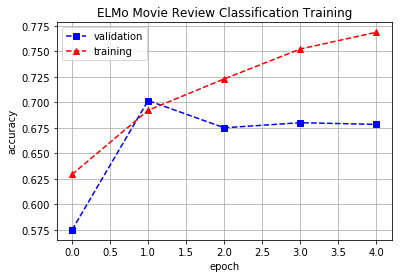

In [19]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(history.history)

fig,ax = plt.subplots()
plt.plot(range(df_history.shape[0]),df_history['val_acc'],'bs--',label='validation')
plt.plot(range(df_history.shape[0]),df_history['acc'],'r^--',label='training')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ELMo Movie Review Classification Training')
plt.legend(loc='best')
plt.grid()
plt.show()

fig.savefig('ELMoConvergence.eps', format='eps')
fig.savefig('ELMoConvergence.pdf', format='pdf')
fig.savefig('ELMoConvergence.png', format='png')
fig.savefig('ELMoConvergence.svg', format='svg')

**Make figures downloadable to local system in interactive mode**

In [20]:
from IPython.display import HTML
def create_download_link(title = "Download file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

create_download_link(filename='ELMoConvergence.svg')

In [21]:
# you must remove all downloaded files - having too many of them on completion will make Kaggle reject your notebook 
!rm -rf aclImdb
!rm aclImdb_v1.tar.gz